In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
data_sat = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/phase_1/04265_to_05570-initial_states.csv')
data_sat['Timestamp']= pd.to_datetime(data_sat['Timestamp'])

In [3]:
data_omni = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/phase_1/omni2/omni2-04265-20180402_to_20180601.csv')
data_omni['Timestamp'] = pd.to_datetime(data_omni['Timestamp'])
data_omni = data_omni.ffill()

In [13]:
import os

In [31]:
data_sat

,File ID,Timestamp,Semi-major Axis (km),Eccentricity,Inclination (deg),RAAN (deg),Argument of Perigee (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (km)
0,4265,2018-06-01 09:44:41,6872.709635,0.001496,88.994611,237.961000,242.048806,117.927141,81.220743,-151.683059,517641.655466
1,4266,2018-06-01 12:53:50,6872.709186,0.001497,88.994611,237.943417,241.463500,118.513240,81.301362,160.926490,517727.804474
2,4267,2018-06-02 12:32:26,6872.706856,0.001508,88.994611,237.811083,237.068306,122.914029,81.546393,165.350031,517418.246022
3,4268,2018-06-02 14:07:01,6872.706712,0.001508,88.994611,237.802306,236.771000,123.211716,81.273988,141.445143,517406.312625
4,4269,2018-06-03 13:45:37,6872.705148,0.001520,88.994611,237.670000,232.412917,127.576295,81.528922,145.873421,517008.340258
...,...,...,...,...,...,...,...,...,...,...,...
1301,5566,2020-12-27 21:12:39,6871.341492,0.001478,88.984694,111.733000,243.646611,116.329037,82.964345,64.838151,516481.793783
1302,5567,2020-12-28 19:16:17,6871.338306,0.001487,88.984806,111.608194,239.521806,120.458756,83.094553,93.056446,516219.988361
1303,5568,2020-12-29 06:18:06,6871.336764,0.001492,88.984806,111.545806,237.472111,122.511124,83.163338,-72.837514,515943.223812
1304,5569,2020-12-30 02:47:11,6871.334171,0.001501,88.984806,111.430000,233.670500,126.318221,82.846877,-21.454523,515454.482158


In [22]:
all_files_omni[0].split('-')

['omni2', '00000', '20000603_to_20000802.csv']

In [43]:
def create_features(id):
    all_files_omni = os.listdir("C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/phase_1/omni2/")
    file_omni = [i for i in all_files_omni if i.split('-')[1]==id][0]
    data_omni = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/phase_1/omni2/'+file_omni)
    data_omni['Timestamp'] = pd.to_datetime(data_omni['Timestamp'])
    data_omni = data_omni.ffill()
    df_features = pd.concat([data_omni.mean(0),data_omni.iloc[-1]],axis=1)
    df_features.columns = ['mean','last']
    return df_features

In [49]:
create_features('00000').unstack().reset_index()

,level_0,level_1,0
0,mean,YEAR,2000.0
1,mean,DOY,184.708333
2,mean,Hour,11.5
3,mean,Bartels_rotation_number,2278.560417
4,mean,ID_for_IMF_spacecraft,70.458333
...,...,...,...
111,last,Proton_flux_>10_Mev,0.47
112,last,Proton_flux_>30_Mev,0.35
113,last,Proton_flux_>60_Mev,0.26
114,last,Flux_FLAG,-1


In [44]:
df_features = pd.concat([data_omni.mean(0),data_omni.iloc[-1]],axis=1)

In [6]:
data_pred = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/phase_1/sat_density/gr-of1-04265-20180601_to_20180604.csv')
data_pred['Timestamp'] = pd.to_datetime(data_pred['Timestamp'])

In [7]:
data_pred

,Timestamp,Orbit Mean Density (kg/m^3)
0,2018-06-01 09:44:50,8.599513e-14
1,2018-06-01 09:54:50,8.743586e-14
2,2018-06-01 10:04:50,8.813977e-14
3,2018-06-01 10:14:50,8.721666e-14
4,2018-06-01 10:24:50,8.591679e-14
...,...,...
427,2018-06-04 08:54:50,5.234490e-14
428,2018-06-04 09:04:50,5.238471e-14
429,2018-06-04 09:14:50,5.201108e-14
430,2018-06-04 09:24:50,5.110281e-14


In [8]:
from atm_me import PersistenceMSIS, MSISPersistenceAtmosphere, PersistenceModel

In [11]:
data_sat.iloc[0].to_dict()



{'File ID': 4265,
 'Timestamp': Timestamp('2018-06-01 09:44:41'),
 'Semi-major Axis (km)': 6872.709634521393,
 'Eccentricity': 0.0014959999825805,
 'Inclination (deg)': 88.99461111111111,
 'RAAN (deg)': 237.961,
 'Argument of Perigee (deg)': 242.0488055555556,
 'True Anomaly (deg)': 117.92714131157383,
 'Latitude (deg)': 81.22074259961417,
 'Longitude (deg)': -151.68305852747133,
 'Altitude (km)': 517641.6554662157}

Starting propagation...: 100%|███████████████████████████████████████████████████████| 431/431 [05:19<00:00,  1.35it/s]


432
Time interval [s]: 259200.0
Time step [s]: 600.0
CPU time [s]: 321.69941759109497
Final Pos [km]: 6393955.418185737
Final Vel [km]: 0.2109043135108621


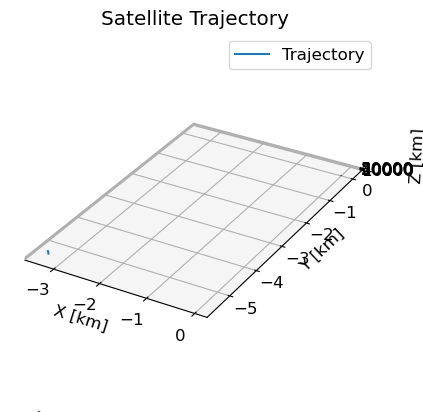

In [12]:
model = PersistenceModel(plot_trajectory=True)
states, densities = model(data_omni,data_sat.iloc[0].to_dict())
predictions = model._convert_to_df(states, densities)

In [68]:
from evaluation_me import DensityModelEvaluator

In [71]:
a  = DensityModelEvaluator('te','te')

In [73]:
a._rmse(predictions.set_index('Timestamp'),data_pred.set_index('Timestamp'))

7.228579809166593e-14

In [10]:
predictions.index

NameError: name 'predictions' is not defined

In [52]:
data_sat.iloc[0]

File ID                                     4265
Timestamp                    2018-06-01 09:44:41
Semi-major Axis (km)                 6872.709635
Eccentricity                            0.001496
Inclination (deg)                      88.994611
RAAN (deg)                               237.961
Argument of Perigee (deg)             242.048806
True Anomaly (deg)                    117.927141
Latitude (deg)                         81.220743
Longitude (deg)                      -151.683059
Altitude (km)                      517641.655466
Name: 0, dtype: object

In [51]:
states[100].date

<AbsoluteDate: 2018-06-01T16:40:00.000Z>

<Axes: xlabel='Timestamp'>

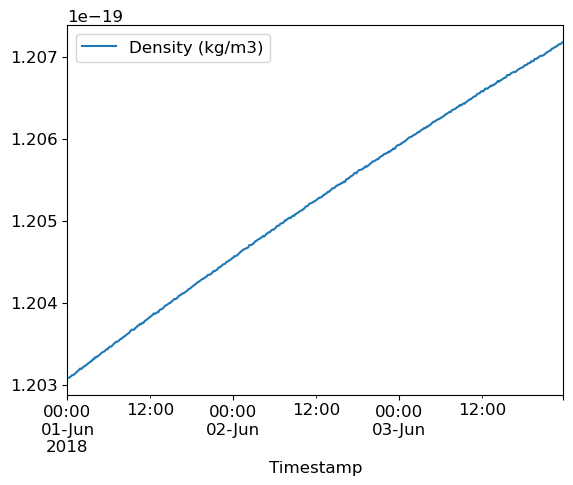

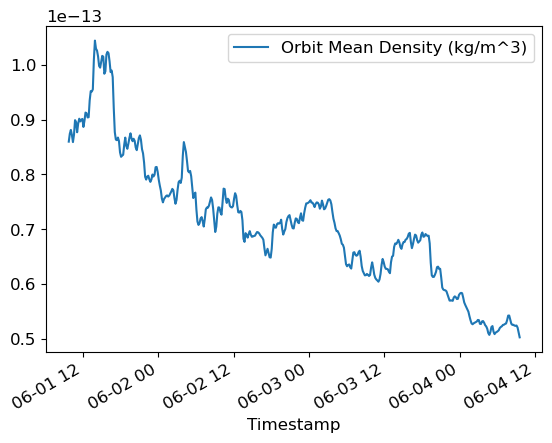

In [46]:
predictions.set_index('Timestamp').plot()
data_pred.set_index('Timestamp').plot()

In [ ]:
from